# Convolution Neural Network Walk-through 

In this tutorial, we will be applying a convolutional neural network to the data for the kaggle data science bowl
- Link: https://www.kaggle.com/c/data-science-bowl-2017/

Checking out the patients and their associated labels

In [22]:
# Packages
import cv2
import dicom
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import pandas as pd
import scipy.ndimage
import tensorflow as tf

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Inline plots in notebook
%matplotlib inline

In [7]:
data_dir = os.getcwd() + '/input/sample_images/'

# List of patients 
# Need to ignore the .DS_Store file created
patients = [item for item 
    in os.listdir(data_dir) 
    if not item.startswith('.')]
print(len(patients))
print(patients[0])
labels_df = pd.read_csv(os.getcwd()+'/input/stage1_labels.csv', index_col=0)
labels_df.head()

20
00cba091fa4ad62cc3200a657aeb957e


,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


In [3]:
student_tuples = [
        ('john', 'A', 15),
        ('jane', 'B', 12),
        ('dave', 'B', 10),
]

# Sorting by age
sorted(student_tuples, key=lambda student : student[2]) 

[('dave', 'B', 10), ('jane', 'B', 12), ('john', 'A', 15)]

## Working with Dicom Files

Just messing around with the dicom files and getting familiar with the data set

In [4]:
print('Number of patients: {}'.format(len(patients)))


for patient in patients[:1]:
    
    #Whether the patient has cancer or not
    label = labels_df.get_value(patient, 'cancer')
    
    #Patient id is linked to their associated dicom folder
    path = data_dir + patient
    
    # a couple great 1-liners from: https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial
    # Retrieve each slice from the patient dicom file
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    
    print('Patient Id: {}'.format(patient))
    print('Label for patient: {}'.format(label))
    print('Number of slices: {}'.format(len(slices)))
    print('Type of slice: {}'.format(type(slices[0])))
    print('Attributes of patient dicom slice: {}'.format(slices[0].dir()))    
    #print(slices[0].ImagePositionPatient)
    
    # Sorting by z-axis - Retrieves len of z
    #slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    #print(slices[0].ImagePositionPatient)
    #print(slices[0].pixel_array.shape, len(slices))
    #print(slices[0])
    print(slices[0].PixelSpacing)
    #plt.imshow(slices[0].pixel_array)
    #plt.show()

Number of patients: 20
Patient Id: 00cba091fa4ad62cc3200a657aeb957e
Label for patient: 0
Number of slices: 134
Type of slice: <class 'dicom.dataset.FileDataset'>
Attributes of patient dicom slice: ['AcquisitionNumber', 'BitsAllocated', 'BitsStored', 'Columns', 'FrameOfReferenceUID', 'HighBit', 'ImageOrientationPatient', 'ImagePositionPatient', 'InstanceNumber', 'KVP', 'Modality', 'PatientBirthDate', 'PatientID', 'PatientName', 'PatientOrientation', 'PhotometricInterpretation', 'PixelData', 'PixelPaddingValue', 'PixelRepresentation', 'PixelSpacing', 'PositionReferenceIndicator', 'RescaleIntercept', 'RescaleSlope', 'Rows', 'SOPClassUID', 'SOPInstanceUID', 'SamplesPerPixel', 'SeriesDescription', 'SeriesInstanceUID', 'SeriesNumber', 'SliceLocation', 'SpecificCharacterSet', 'StudyInstanceUID', 'WindowCenter', 'WindowWidth']
['0.597656', '0.597656']


In [5]:
# Load the scans in given folder path
# Calculating slice thickness
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    
    #Sort slices by z-plane
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    
    # Thickness between slices
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    
    # Creating slice thickness attribute
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices

(3, 4, 10)
(3, 4, 12)
(3, 4, 15)


CT Scan Information: The units of CT scans is the Hounsfield Unit (HU), which is a measure of radiodensity.

### CT Scan analysis

In [7]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

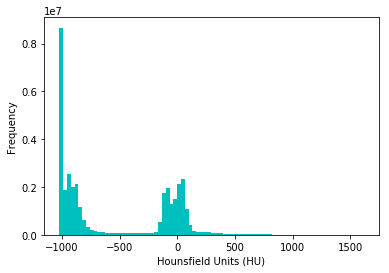

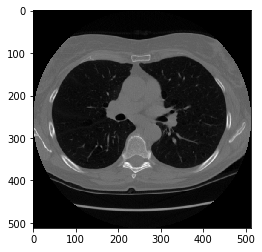

In [9]:
first_patient = load_scan(data_dir + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

Many of the scans meta data differs from scan to scan. More importantly, the size of the scans differs so we need to do some work in normalizing the scans from patient to patient. Note: The difference in pixel size/ coarseness can hurt performances of CNN approaches.

## Processing and viewing our data

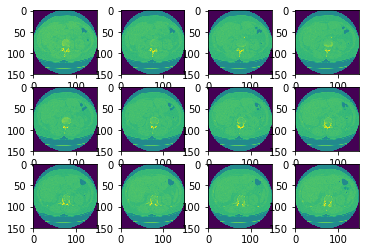

In [10]:
# Resizing our images from 512x512 to 150x150
# Note: This is still too large
IMG_PX_SIZE = 150

for patient in patients[:1]:
    if patient == '.DS_Store': continue
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    fig = plt.figure()
    for num,each_slice in enumerate(slices[:12]):
        y = fig.add_subplot(3,4,num+1)
        new_img = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
        y.imshow(new_img)
    plt.show()

In [4]:
def divide_list(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]
        
chunks = divide_list([1,2,3,4,5,6,7,8,], 2)
for chunk in chunks:
    print(chunk)

[1, 2]
[3, 4]
[5, 6]
[7, 8]


In [13]:
def mean(l):
    return sum(l) / len(l)

IMG_PX_SIZE = 150
HM_SLICES = 20

for patient in patients[:10]:
    try:
        label = labels_df.get_value(patient, 'cancer')
        path = data_dir + patient
        slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        new_slices = []
        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
        chunk_sizes = math.ceil(len(slices) / HM_SLICES)
        for slice_chunk in divide_list(slices, chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)

        print(len(slices), len(new_slices))
    except:
        print('Patient {} does not have label'.format(patient))
        pass


134 20
128 19
133 19
110 19
203 19
Patient 0b20184e0cd497028bdd155d9fb42dc9 does not have label
280 20
123 18
164 19
244 19


In [14]:
for patient in patients[:10]:
    try:
        label = labels_df.get_value(patient, 'cancer')
        path = data_dir + patient
        slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        new_slices = []

        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]

        chunk_sizes = math.ceil(len(slices) / HM_SLICES)


        for slice_chunk in divide_list(slices, chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)

        if len(new_slices) == HM_SLICES-1:
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES-2:
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES+2:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        if len(new_slices) == HM_SLICES+1:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        print(len(slices), len(new_slices))
    except Exception as e:
        # again, some patients are not labeled, but JIC we still want the error if something
        # else is wrong with our code
        print(str(e))

134 20
128 20
133 20
110 20
203 20
'0b20184e0cd497028bdd155d9fb42dc9'
280 20
123 20
164 20
244 20


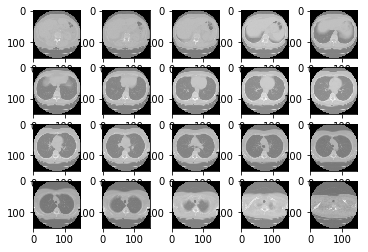

In [15]:
for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    new_slices = []

    slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / HM_SLICES)
    for slice_chunk in divide_list(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == HM_SLICES-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES+2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
        
    if len(new_slices) == HM_SLICES+1:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
    
    fig = plt.figure()
    for num,each_slice in enumerate(new_slices):
        y = fig.add_subplot(4,5,num+1)
        y.imshow(each_slice, cmap='gray')
    plt.show()

In [26]:
IMG_SIZE_PX = 50
SLICE_COUNT = 20

def process_data(patient, labels_df, img_px_size=50, hm_slices=20, visualize=False):
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))

    new_slices = []
    slices = [cv2.resize(np.array(each_slice.pixel_array),(img_px_size,img_px_size)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / hm_slices)
    for slice_chunk in divide_list(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == hm_slices-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices+2:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val
        
    if len(new_slices) == hm_slices+1:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val

    if visualize:
        fig = plt.figure()
        for num,each_slice in enumerate(new_slices):
            y = fig.add_subplot(4,5,num+1)
            y.imshow(each_slice, cmap='gray')
        plt.show()
    
    #One-hot encoding
    if label == 1: label=np.array([0,1])
    elif label == 0: label=np.array([1,0])
        
    return np.array(new_slices),label

# stage 1 for real.
patients = os.listdir(data_dir)
labels = labels_df
print(len(patients))
much_data = []
for num,patient in enumerate(patients):
    if num % 100 == 0:
        print(num)
    try:
        img_data,label = process_data(patient,labels,img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
        much_data.append([img_data,label])
    except KeyError as e:
        print('This is unlabeled data!')

np.save('muchdata-{}-{}-{}.npy'.format(IMG_SIZE_PX,IMG_SIZE_PX,SLICE_COUNT), much_data)

21
0
This is unlabeled data!
This is unlabeled data!


### Resampling

A scan may have a pixel spacing of [2.5, 0.5, 0.5], which means that the distance between slices is 2.5mm.

In [11]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [12]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

[ 2.5         0.59765601  0.59765601]
Shape before resampling	 (134, 512, 512)
Shape after resampling	 (335, 306, 306)


### 3D Visualization

In [13]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

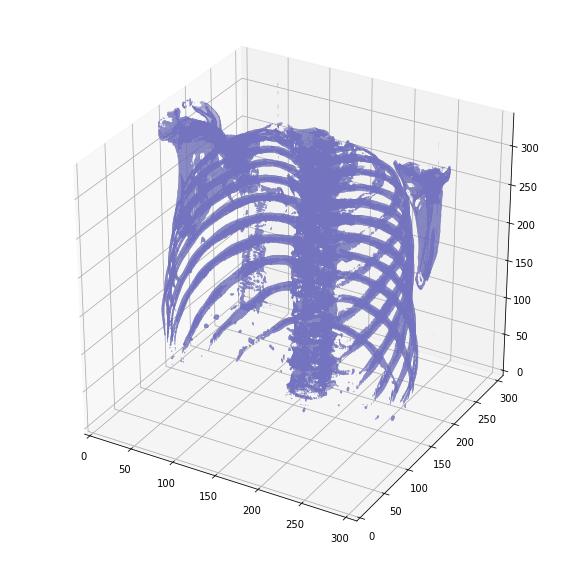

In [14]:
plot_3d(pix_resampled, 400)

### Convolutional Neural Network

In [31]:
much_data = np.load('muchdata-50-50-20.npy')
# If you are working with the basic sample data, use maybe 2 instead of 100 here... you don't have enough data to really do this
train_data = much_data[:-2]
validation_data = much_data[-2:]

n_classes = 2

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.8

def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    #                        size of window         movement of window as you slide about
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')


def convolutional_neural_network(x):
    #                # 5 x 5 x 5 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               #       5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),
               #                                  64 features
               'W_fc':tf.Variable(tf.random_normal([54080,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, 54080])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output


In [34]:
def train_neural_network(x):
    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    
    hm_epochs = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        successful_runs = 0
        total_runs = 0
        
        for epoch in range(hm_epochs):
            epoch_loss = 0
            for data in train_data:
                total_runs += 1
                try:
                    X = data[0]
                    Y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_runs += 1
                except Exception as e:
                    # I am passing for the sake of notebook space, but we are getting 1 shaping issue from one 
                    # input tensor. Not sure why, will have to look into it. Guessing it's
                    # one of the depths that doesn't come to 20.
                    pass
                    #print(str(e))
            
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

            print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
            
        print('Done. Finishing accuracy:')
        print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
        
        print('fitment percent:',successful_runs/total_runs)

# Run this locally:
train_neural_network(x)

Epoch 1 completed out of 10 loss: 6687686784.0
Accuracy: 1.0
Epoch 2 completed out of 10 loss: 26286616128.0
Accuracy: 0.5
Epoch 3 completed out of 10 loss: 19612422144.0
Accuracy: 0.5
Epoch 4 completed out of 10 loss: 6009629184.0
Accuracy: 1.0
Epoch 5 completed out of 10 loss: 11699068608.0
Accuracy: 0.0
Epoch 6 completed out of 10 loss: 4735323200.0
Accuracy: 0.0
Epoch 7 completed out of 10 loss: 9889329048.0
Accuracy: 0.5
Epoch 8 completed out of 10 loss: 865201584.0
Accuracy: 0.5
Epoch 9 completed out of 10 loss: 3426298416.0
Accuracy: 0.5
Epoch 10 completed out of 10 loss: 1449379040.0
Accuracy: 0.5
Done. Finishing accuracy:
Accuracy: 1.0
fitment percent: 1.0


Try adding noise